Problem: For pseudobulk I am able to compute distances between control and perturbations, but that's it. I do not get a reference to compare against. I can not express the distance wrt something like the control distributions shape. I guess what would be closest to this is **replicates**.

In [1]:
import subprocess
import os
import sys
import matplotlib.backends.backend_pdf
import scanpy as sc
import matplotlib.pyplot as pl
import anndata as ad
import pandas as pd
import numpy as np
import scvelo as scv
scv.settings.verbosity=1

# Jupyter stuff
from tqdm.notebook import tqdm
from IPython.display import clear_output
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
%matplotlib inline

# Custom functions
sys.path.insert(1, '../..')
from utils import *

In [2]:
# paths
at_home = False if '/fast/work/users/' in os.getcwd() else True
data_path = '/extra/stefan/data/perturbation_resource_paper/' if at_home else '/fast/work/users/peidlis_c/data/perturbation_resource_paper/'
signatures_path = '/home/peidli/utils/scrnaseq_signature_collection/' if at_home else '/fast/work/users/peidlis_c/utils/scrnaseq_signature_collection/'
utils_path = '/extra/stefan/utils/scrnaseq_utils/' if at_home else '/fast/work/users/peidlis_c/utils/single_cell_rna_seq/scrnaseq_utils/'

# Stefan's utils
sys.path.insert(1, utils_path)
from scrnaseq_util_functions import *

In [3]:
h5_files = {}
for path, subdirs, files in os.walk(data_path):
    for name in files:
        if '.h5' in name: h5_files[name[:-3]] = os.path.join(path, name)
del h5_files['exampledataset']
del h5_files['NormanWeissman2019_raw']
del h5_files['PapalexiSatija2021_eccite_arrayed_protein']
del h5_files['PapalexiSatija2021_eccite_protein']
del h5_files['FrangiehIzar2021_protein']
print(len(h5_files))
list(h5_files.keys())

39


['PapalexiSatija2021_eccite_arrayed_RNA',
 'PapalexiSatija2021_eccite_RNA',
 'TianKampmann2021_CRISPRa',
 'TianKampmann2021_CRISPRi',
 'XieHon2017',
 'AissaBenevolenskaya2021',
 'McFarlandTshemiak2020_all_expts_combined',
 'GasperiniShendure2019_lowMOI',
 'GasperiniShendure2019_atscale',
 'GasperiniShendure2019_highMOI',
 'ZhaoSims2021',
 'DixitRegev2016',
 'DatlingerBock2017',
 'DatlingerBock2021',
 'FrangiehIzar2021_RNA',
 'WeinrebKlein2020',
 'ShifrutMarson2018',
 'ReplogleWeissman2022_K562_essential',
 'ReplogleWeissman2022_K562_gwps',
 'ReplogleWeissman2022_rpe1',
 'ChangYe2021',
 'gene_scores',
 'peak_bc',
 'ChromVar',
 'LSI_embedding',
 'markerpeak_target',
 'SchiebingerLander2019_GSE115943',
 'SchiebingerLander2019_GSE106340',
 'NormanWeissman2019_filtered',
 'SchraivogelSteinmetz2020_TAP_SCREEN__chromosome_11_screen',
 'SchraivogelSteinmetz2020_TAP_SCREEN__chromosome_8_screen',
 'AdamsonWeissman2016_GSM2406677_10X005',
 'AdamsonWeissman2016_GSM2406681_10X010',
 'AdamsonWeissma

In [4]:
def plot_heatmap(tab, title, ax):
    if 'simple_confusion' in title:
        tab = pd.DataFrame(zscore(tab.values, axis=0), tab.index, tab.columns)
        tab = 0.5 * (tab+tab.T)
        tab = cluster_matrix(tab, 'both')
    sns.heatmap(tab, robust=True, ax=ax)
    ax.set_xticks(np.arange(len(tab))+.5)
    ax.set_xticklabels(tab.index, fontsize=6)
    ax.set_yticks(np.arange(len(tab))+.5)
    ax.set_yticklabels(tab.index, fontsize=6)
    ax.set_title(title)

In [5]:
tres = get_subfolders('./analysis_screens/tessa_results/', False)

In [6]:
modes=['pairwise_pca_distances', 'pseudobulk_distances', 'pseudobulk_correlations']

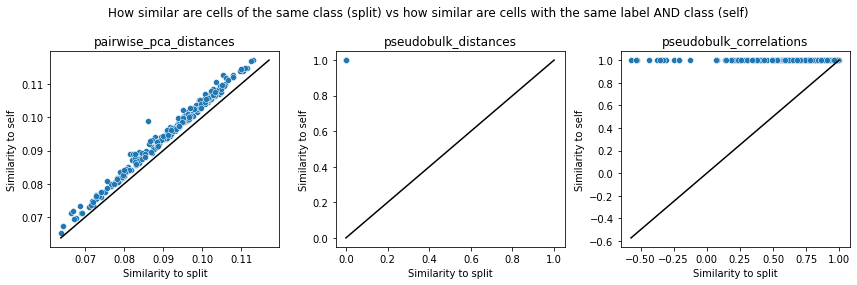

In [22]:
N = len(modes)
fig, axs = pl.subplots(1,N,figsize=[4*N, 4])
tabs = {}
for ax, mode in zip(axs, modes):
    key = 'NormanWeissman2019_filtered'  # AdamsonWeissman2016_GSM2406681_10X010
    sim = pd.read_csv(f'./analysis_screens/tables/split_{mode}_{key}_tables.csv', index_col=0)
    
    classes = pd.unique([x.replace('_X', '') for x in sim.index])
    res = {}
    for c in classes:
        # this is pretty pointless to compare.
        res[c] = [sim.loc[c, c+'_X'], np.mean([sim.loc[c, c], sim.loc[c+'_X', c+'_X']])]
    df = pd.DataFrame(res, index=['split', 'self']).T
    
    sns.scatterplot(data=df, x='split', y='self', ax=ax)
    m = np.max(df.values)
    n = np.min(df.values)
    ax.plot([n,m], [n,m], c='k')
    ax.set_title(mode)
    ax.set_ylabel('Similarity to self')
    ax.set_xlabel('Similarity to split')
pl.suptitle('How similar are cells of the same class (split) vs how similar are cells with the same label AND class (self)')
pl.tight_layout()
pl.show()

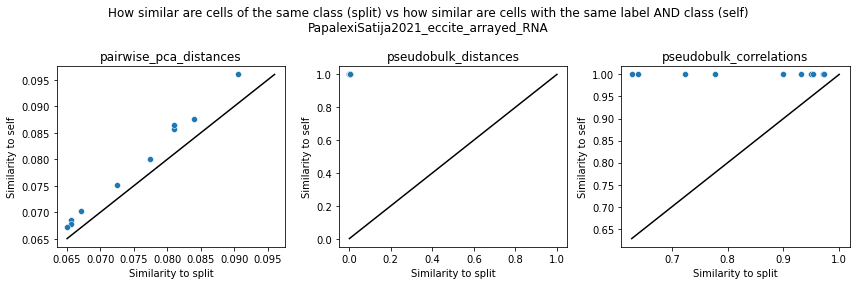

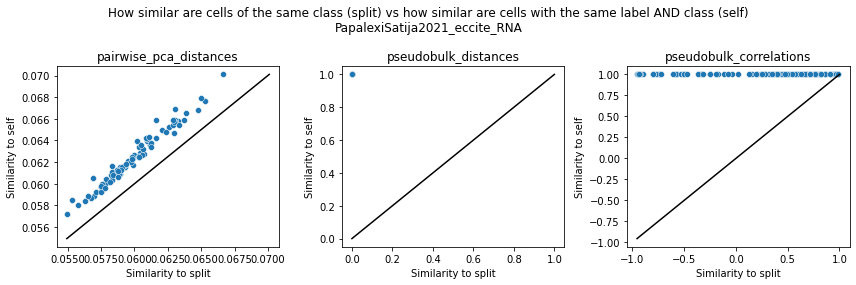

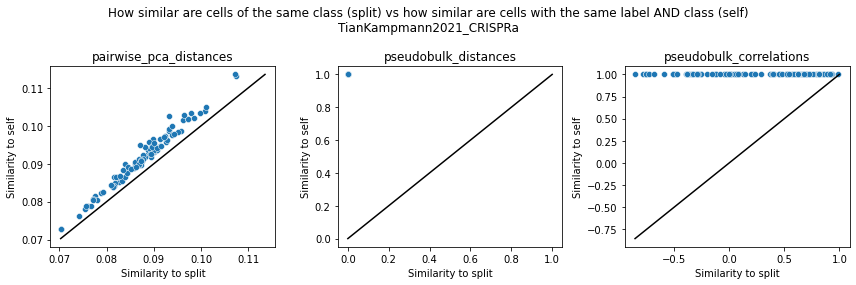

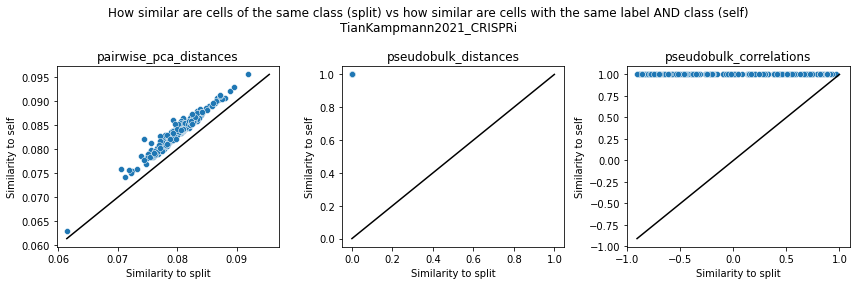

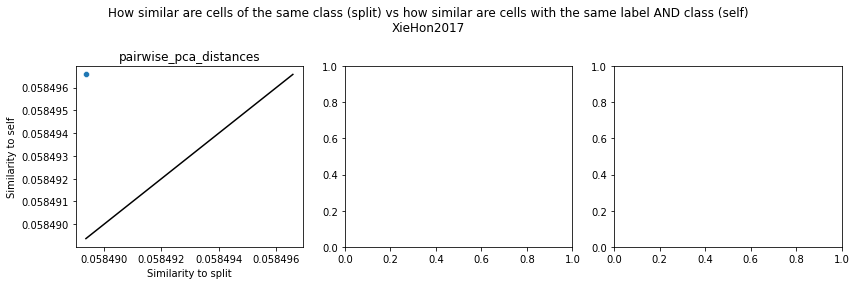

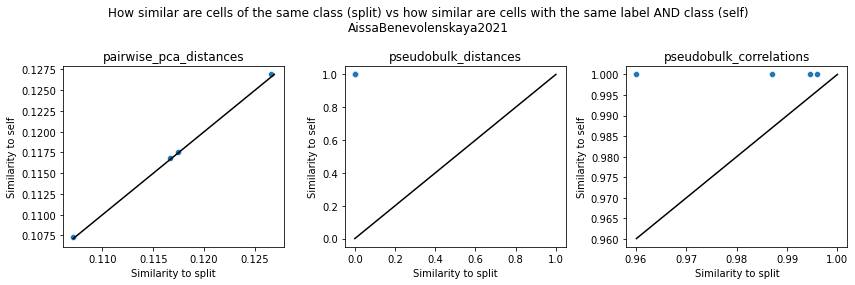

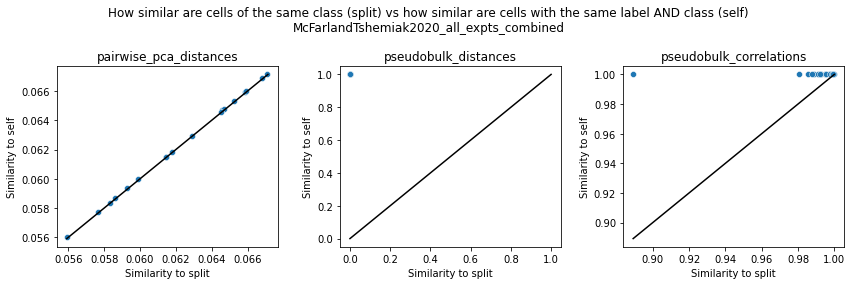

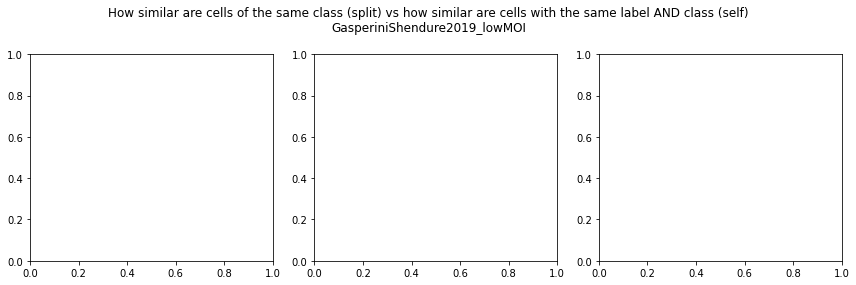

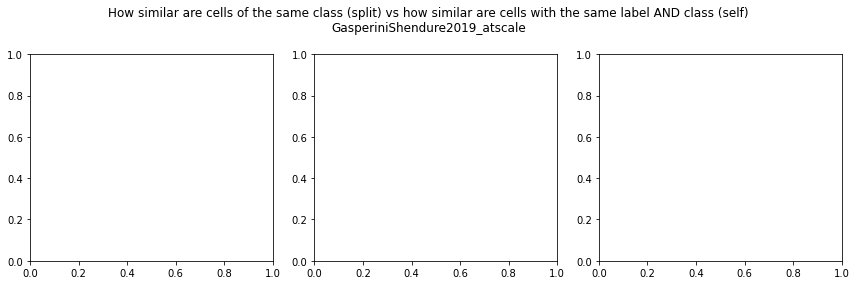

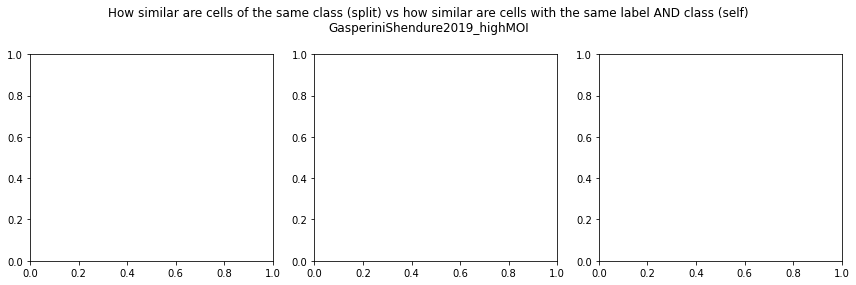

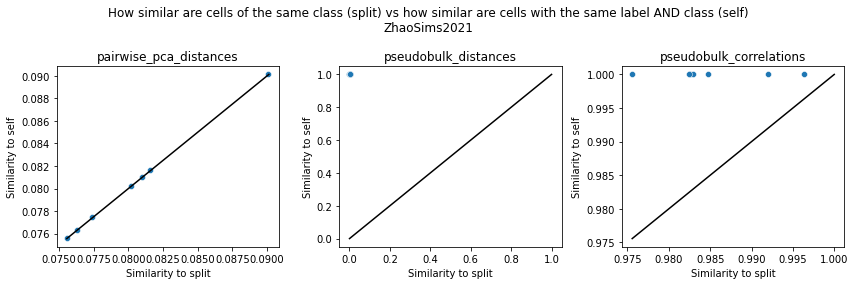

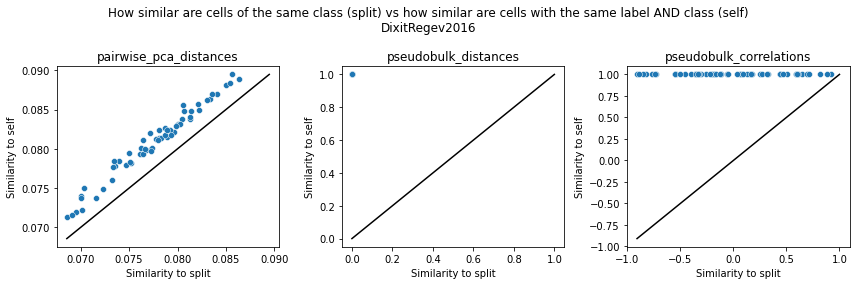

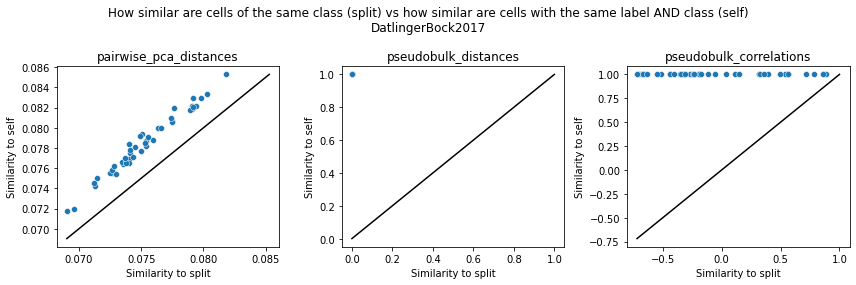

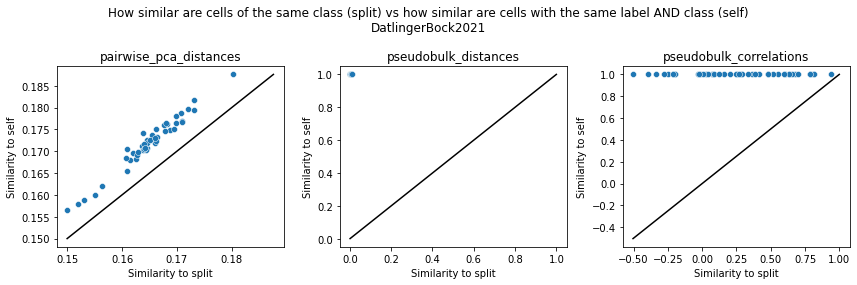

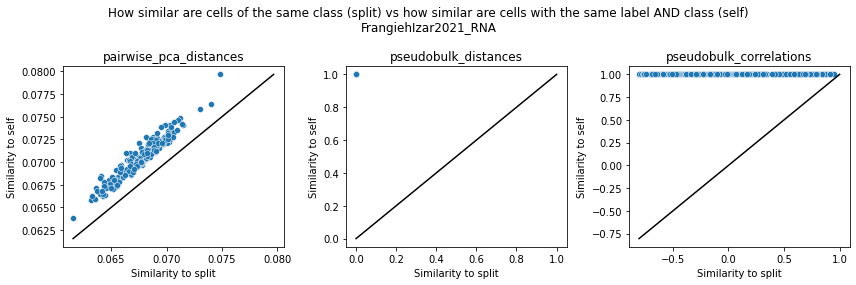

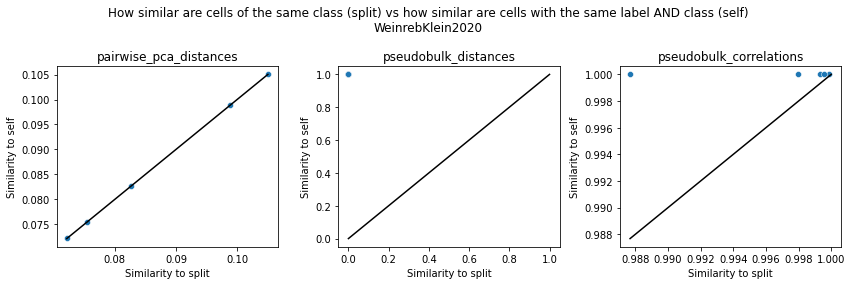

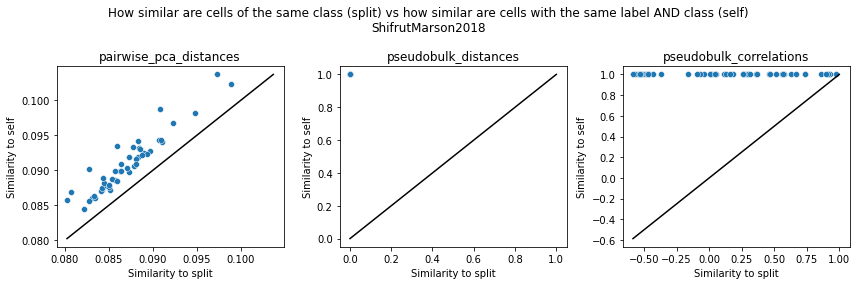

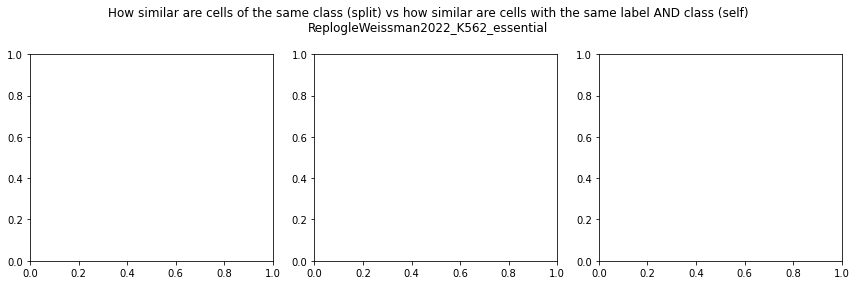

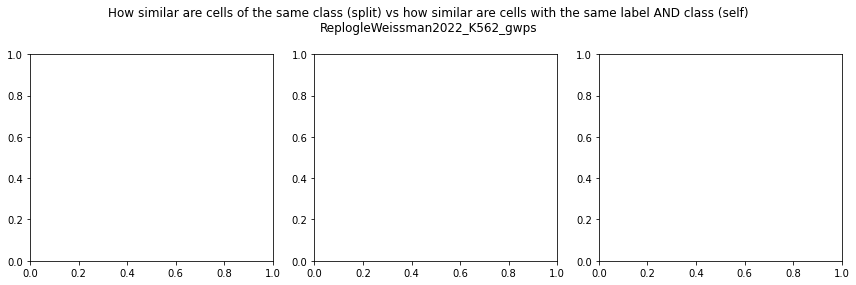

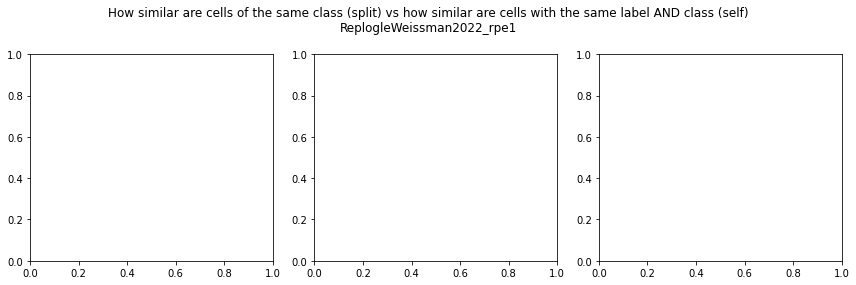

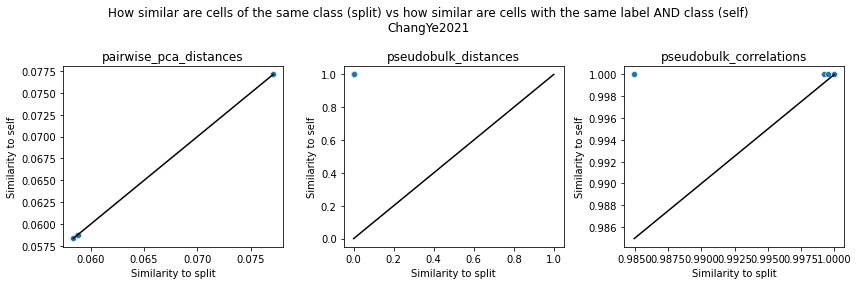

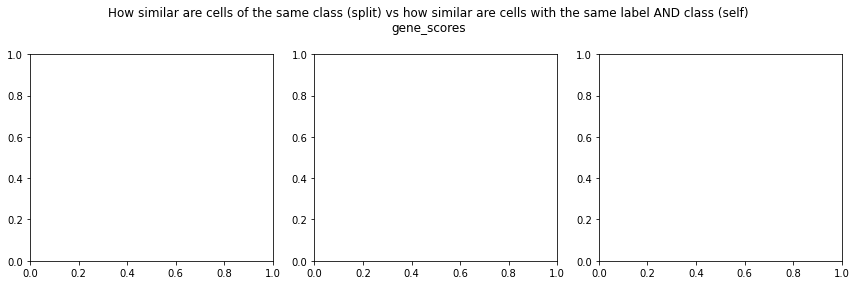

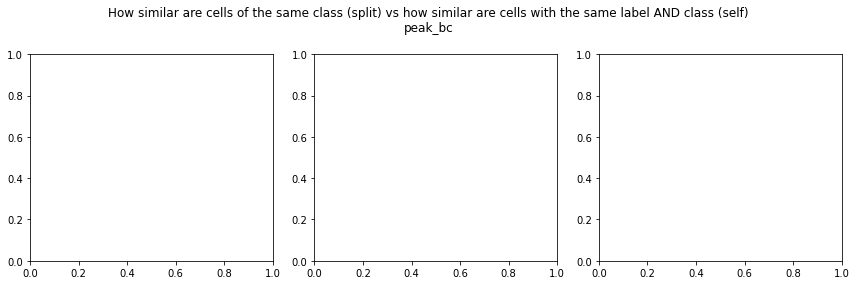

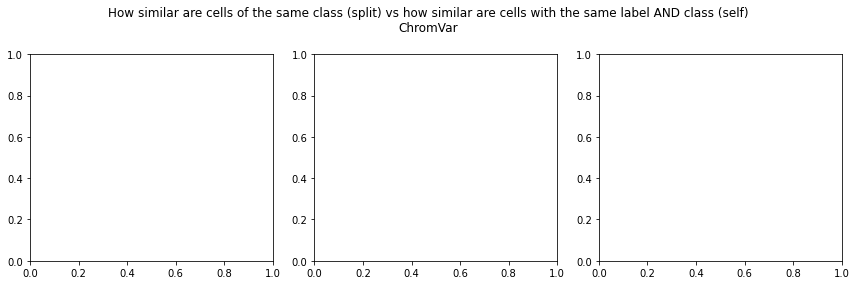

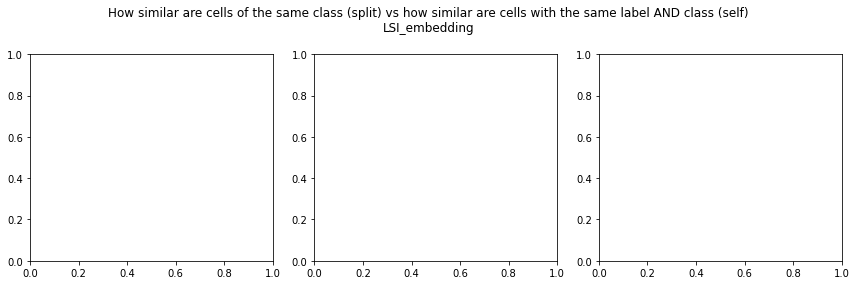

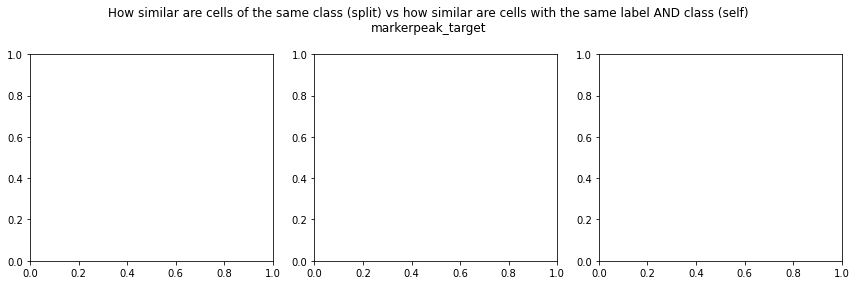

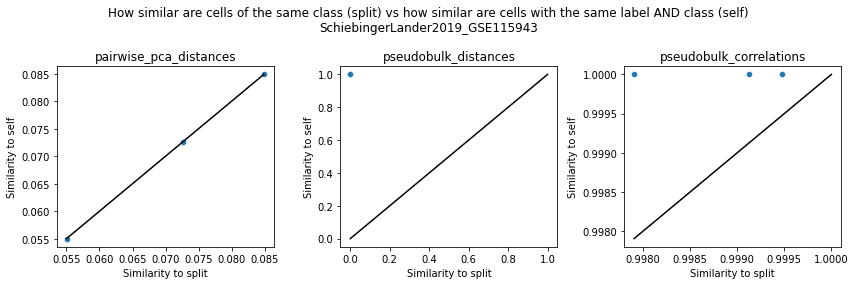

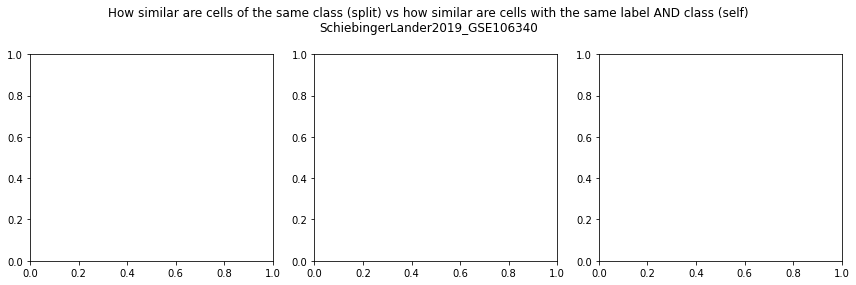

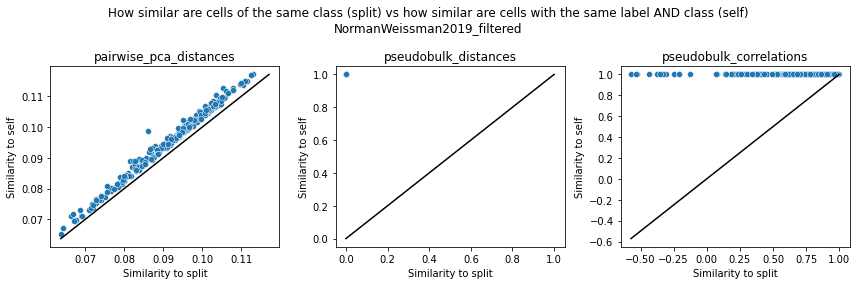

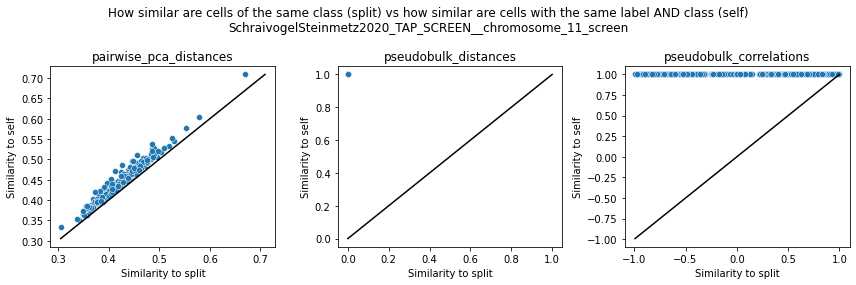

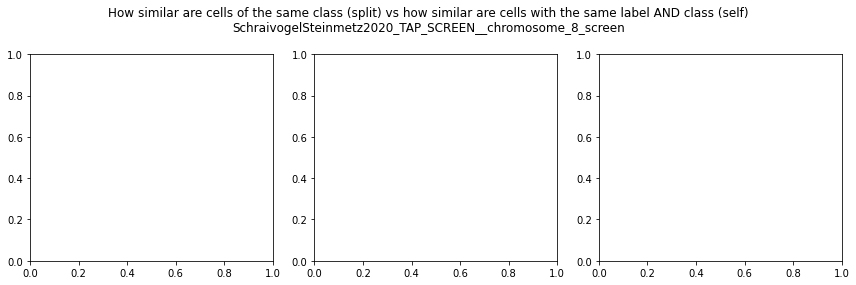

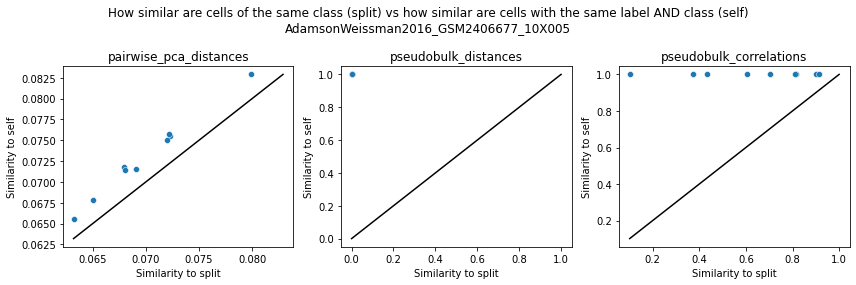

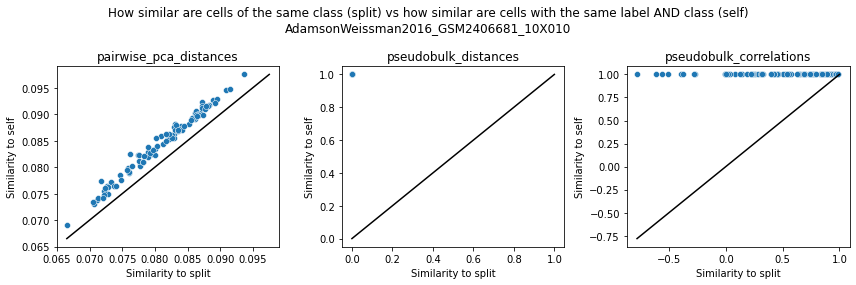

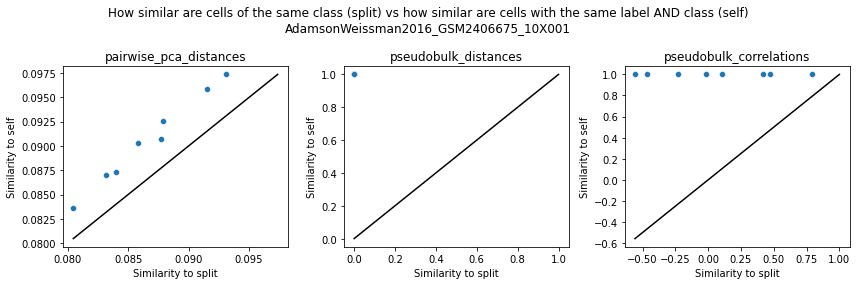

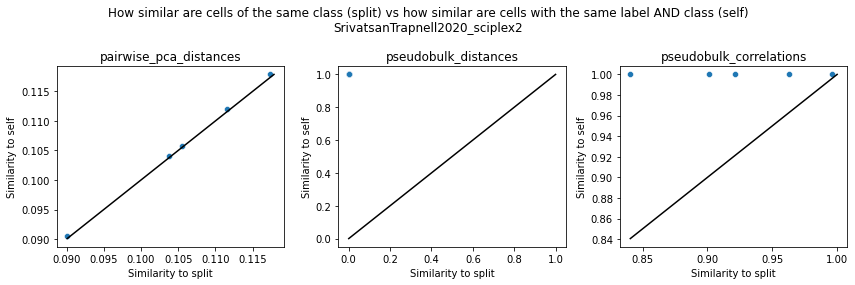

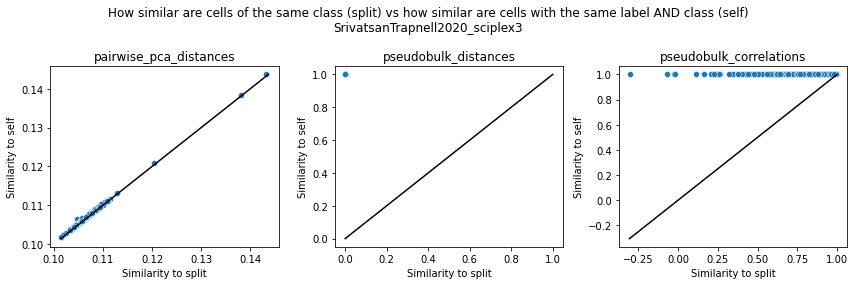

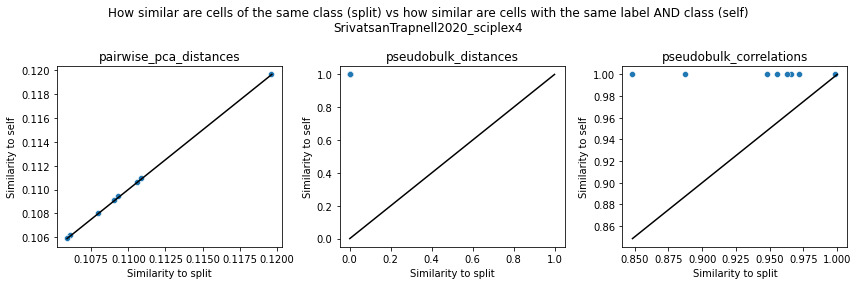

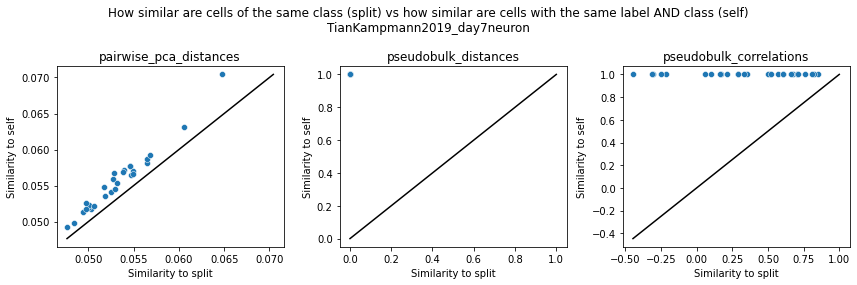

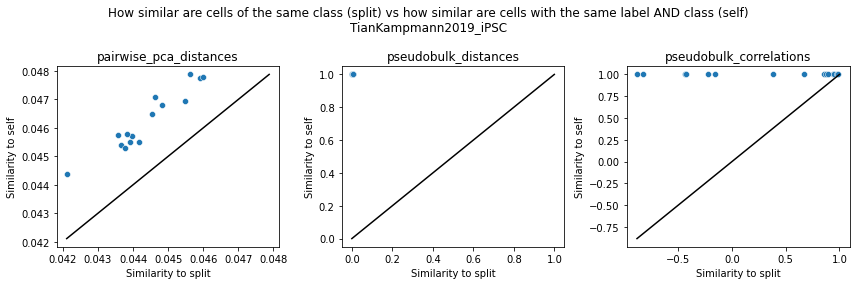

In [8]:
N = len(modes)
for key in h5_files.keys():
    fig, axs = pl.subplots(1,N,figsize=[4*N, 4])
    tabs = {}
    for ax, mode in zip(axs, modes):
        try:
            sim = pd.read_csv(f'./analysis_screens/tables/split_{mode}_{key}_tables.csv', index_col=0)
            classes = pd.unique([x.replace('_X', '') for x in sim.index])
        except:
            continue
        res = {}
        for c in classes:
            if False:#mode=='pairwise_pca_distances':
                N = len(classes)
                res[c] = [sim.loc[c, c+'_X'], np.sum([sim.loc[c, c], sim.loc[c+'_X', c+'_X']])/ (N*N-N)]
            else:
                res[c] = [sim.loc[c, c+'_X'], np.mean([sim.loc[c, c], sim.loc[c+'_X', c+'_X']])]
        df = pd.DataFrame(res, index=['split', 'self']).T

        sns.scatterplot(data=df, x='split', y='self', ax=ax)
        m = np.max(df.values)
        n = np.min(df.values)
        ax.plot([n,m], [n,m], c='k')
        ax.set_title(f'{mode}')
        ax.set_ylabel('Similarity to self')
        ax.set_xlabel('Similarity to split')
    pl.suptitle(f'How similar are cells of the same class (split) vs how similar are cells with the same label AND class (self)\n{key}')
    pl.tight_layout()
    pl.show()